In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
#import seaborn as sns
import pandas as pd
import numpy as np
import itertools

In [50]:
folder = Path("results_synced/atlas_ratio/")
datasets = ["GunPoint", "Coffee", "PowerCons", "Plane"]
encoders = ["CNN_DFS"]
folds = 5

dfs = []
for dataset, encoder in itertools.product(datasets, encoders):
    paths = [folder /  f"EXP_ratio_{encoder}_{dataset}_f{f}.csv" for f in range(folds)]
    paths = [p for p in paths if p.exists()] 
    dfs.append(pd.concat([pd.read_csv(p) for p in paths]))
df = pd.concat(dfs, ignore_index=True)

ds = "Coffee"
df["dataset"].value_counts()

GunPoint     150
Coffee       150
PowerCons    150
Plane         40
Name: dataset, dtype: int64

In [51]:
def fix_close_vals(df: pd.DataFrame, col: str):

    unq = df[col].unique()
    df = df.copy()

    good_ones = [0]
    thresh = df[col].max()/10
    for i in unq:
        if np.all(np.array([np.abs(i-j) > thresh for j in good_ones])):
            good_ones.append(i)

    closest = []
    for i in unq:
        closest.append(np.argmin(np.abs(np.array(good_ones) - i)))

    mapping = {}
    for i, ns in enumerate(unq):
        mapping[ns] = unq[closest[i]]
    
    df[col] = df[col].replace(to_replace=mapping).copy()
    
    return df

In [52]:
dfs = df[df["dataset"] == ds].copy()
dfs = fix_close_vals(dfs,  "nsamp_pre")


cols = [c for c in dfs.columns if ("target_test" in c) or (("pretrain_val" in c) )]
xd0 = dfs[dfs["pretrained"] == False].groupby(["nsamp_tra"])[cols].mean()
xd1 = dfs.groupby(["nsamp_tra", "pretrained"])[cols].max()
xd2 = dfs.groupby(["nsamp_tra", "pretrained"])[cols].std()
print(dfs["nsamp_pre"].unique())

xd1.columns = [c + "_mean" for c in xd1.columns]
xd2.columns = [c + "_std" for c in xd2.columns]
xd = pd.concat([xd1, xd2], axis=1).reset_index()
xd.replace(np.NaN, 0, inplace=True)
xd

[   0 1941 3882 5825 7766 9709]


,nsamp_tra,pretrained,target_test_acc_mean,target_test_f1_mean,target_test_auroc_mean,pretrain_val_acc_mean,pretrain_val_f1_mean,pretrain_val_auroc_mean,target_test_acc_std,target_test_f1_std,target_test_auroc_std,pretrain_val_acc_std,pretrain_val_f1_std,pretrain_val_auroc_std
0,683,False,0.456723,0.456723,0.479309,0.000000,0.000000,0.000000,0.040148,0.040148,0.034539,0.000000,0.000000,0.000000
1,683,True,0.470137,0.470137,0.472406,0.860142,0.860142,0.967743,0.027515,0.027515,0.028038,0.142777,0.142777,0.048894
2,1366,False,0.460053,0.460053,0.406265,0.000000,0.000000,0.000000,0.035256,0.035256,0.020971,0.000000,0.000000,0.000000
3,1366,True,0.560524,0.560524,0.567430,0.856248,0.856248,0.967446,0.037753,0.037753,0.057625,0.097346,0.097346,0.043495
4,2050,False,0.578870,0.578870,0.570931,0.000000,0.000000,0.000000,0.095819,0.095819,0.065872,0.000000,0.000000,0.000000
5,2050,True,0.623354,0.623354,0.678395,0.862439,0.862439,0.968322,0.049522,0.049522,0.061214,0.096056,0.096056,0.042969
6,2733,False,0.579163,0.579163,0.563575,0.000000,0.000000,0.000000,0.045843,0.045843,0.047220,0.000000,0.000000,0.000000
7,2733,True,0.709358,0.709358,0.770291,0.849756,0.849756,0.966231,0.063470,0.063470,0.069348,0.093729,0.093729,0.041978
8,3417,False,0.537899,0.537899,0.552044,0.000000,0.000000,0.000000,0.011214,0.011214,0.031345,0.000000,0.000000,0.000000
9,3417,True,0.680294,0.680294,0.713001,0.855872,0.855872,0.967159,0.054709,0.054709,0.070893,0.110088,0.110088,0.046759


Text(0, 0.5, 'f1')

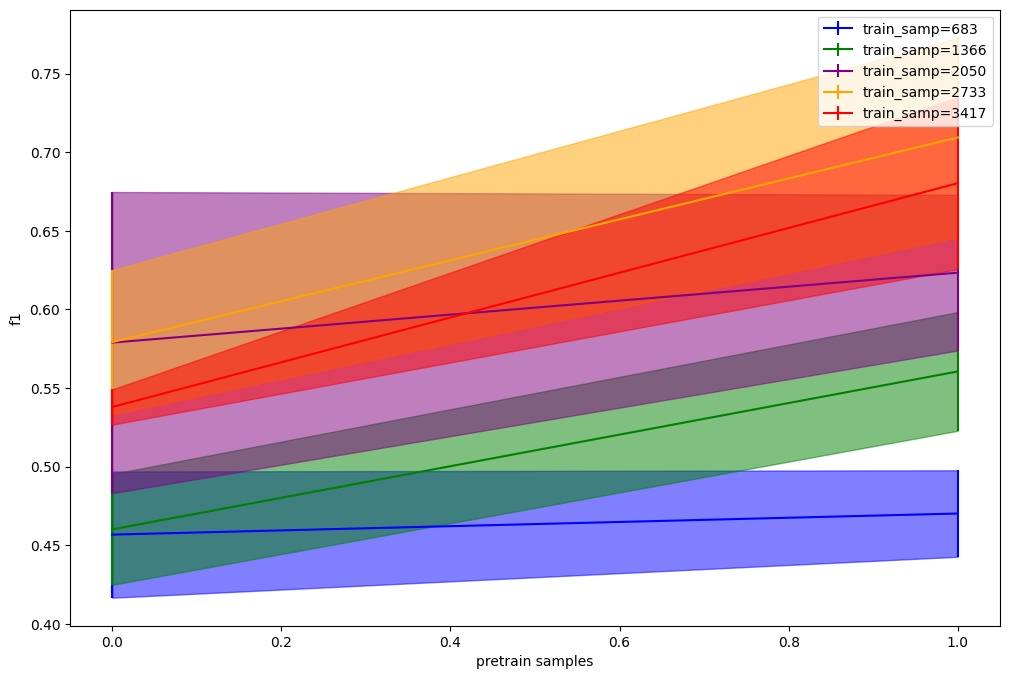

In [53]:
dfs: pd.DataFrame = xd

metric = "f1"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])#plt.subplots(subplot_kw={"projection": "3d"})
for i, (nsamp, dfg) in enumerate(dfs.groupby(dfs["nsamp_tra"])):
    ax.errorbar(dfg["pretrained"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.fill_between(dfg["pretrained"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
        y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.xlabel("pretrain samples")
plt.ylabel(metric)

In [54]:
dfs = df[df["dataset"] == ds].copy()
dfs = fix_close_vals(dfs,  "nsamp_pre")


cols = [c for c in dfs.columns if ("target_test" in c) or (("pretrain_val" in c) )]
xd0 = dfs[dfs["pretrained"] == False].groupby(["nsamp_tra"])[cols].mean()
xd1 = dfs.groupby(["nsamp_tra", "nsamp_pre"])[cols].max()
xd2 = dfs.groupby(["nsamp_tra", "nsamp_pre"])[cols].std()
print(dfs["nsamp_pre"].unique())

xd1.columns = [c + "_mean" for c in xd1.columns]
xd2.columns = [c + "_std" for c in xd2.columns]
xd = pd.concat([xd1, xd2], axis=1).reset_index()
xd.replace(np.NaN, 0, inplace=True)
xd

[   0 1941 3882 5825 7766 9709]


,nsamp_tra,nsamp_pre,target_test_acc_mean,target_test_f1_mean,target_test_auroc_mean,pretrain_val_acc_mean,pretrain_val_f1_mean,pretrain_val_auroc_mean,target_test_acc_std,target_test_f1_std,target_test_auroc_std,pretrain_val_acc_std,pretrain_val_f1_std,pretrain_val_auroc_std
0,683,0,0.456723,0.456723,0.479309,0.000000,0.000000,0.000000,0.040148,0.040148,0.034539,0.000000,0.000000,0.000000
1,683,1941,0.456723,0.456723,0.465554,0.690883,0.690883,0.893214,0.038213,0.038213,0.032272,0.167845,0.167845,0.029082
2,683,3882,0.456723,0.456723,0.467632,0.814235,0.814235,0.938313,0.015863,0.015863,0.041301,0.077874,0.077874,0.037124
3,683,5825,0.469179,0.469179,0.472406,0.858049,0.858049,0.965433,0.012880,0.012880,0.015398,0.116503,0.116503,0.053926
4,683,7766,0.470137,0.470137,0.458906,0.860142,0.860142,0.967743,0.041648,0.041648,0.011338,0.100388,0.100388,0.043001
5,683,9709,0.462101,0.462101,0.452373,0.850161,0.850161,0.960532,0.018780,0.018780,0.016977,0.116198,0.116198,0.046284
6,1366,0,0.460053,0.460053,0.406265,0.000000,0.000000,0.000000,0.035256,0.035256,0.020971,0.000000,0.000000,0.000000
7,1366,1941,0.500798,0.500798,0.458340,0.829060,0.829060,0.954364,0.034284,0.034284,0.045725,0.079477,0.079477,0.036968
8,1366,3882,0.503354,0.503354,0.437833,0.641281,0.641281,0.868315,0.031883,0.031883,0.042746,0.019129,0.019129,0.013194
9,1366,5825,0.521878,0.521878,0.513400,0.850244,0.850244,0.959564,0.034629,0.034629,0.056166,0.096475,0.096475,0.045872


Text(0, 0.5, 'f1')

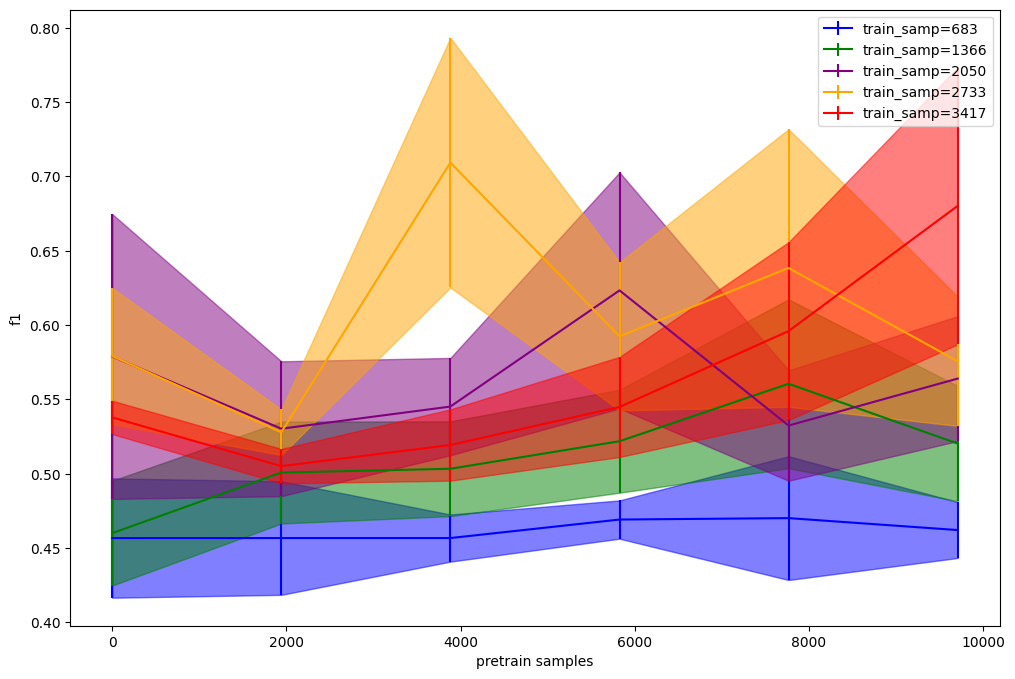

In [55]:
dfs: pd.DataFrame = xd

metric = "f1"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])#plt.subplots(subplot_kw={"projection": "3d"})
for i, (nsamp, dfg) in enumerate(dfs.groupby(dfs["nsamp_tra"])):
    ax.errorbar(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.fill_between(dfg["nsamp_pre"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
        y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.xlabel("pretrain samples")
plt.ylabel(metric)